In [1]:
import base64
import io
import pickle
import numpy as np
import torch
print(f'TORCH VERSION: {torch.__version__}')
import packaging.version
#if packaging.version.parse(torch.__version__) < packaging.version.parse('1.5.0'):
#    raise RuntimeError('Torch versions lower than 1.5.0 not supported')
        
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import time
sns.set_style('whitegrid')

TORCH VERSION: 1.6.0


In [2]:
if torch.cuda.is_available():
    torch_device = 'cuda'
    float_dtype = np.float32 # single
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
else:
    torch_device = 'cpu'
    float_dtype = np.float64 # double
    torch.set_default_tensor_type(torch.DoubleTensor)
print(f"TORCH DEVICE: {torch_device}")

TORCH DEVICE: cpu


In [3]:
def torch_mod(x):
    return torch.remainder(x, 2*np.pi)
def torch_wrap(x):
    return torch_mod(x+np.pi) - np.pi

In [4]:
def grab(var):
    return var.detach().cpu().numpy()

In [5]:
from IPython.display import display

def init_live_plot(dpi=125, figsize=(8,4)):
    fig, ax_ess = plt.subplots(1,1, dpi=dpi, figsize=figsize)
    plt.xlim(0, N_era*N_epoch)
    plt.ylim(0, 1)
    
    ess_line = plt.plot([0],[0], alpha=0.5) # dummy
    plt.grid(False)
    plt.ylabel('ESS')
    
    ax_loss = ax_ess.twinx()
    loss_line = plt.plot([0],[0], alpha=0.5, c='orange') # dummy
    plt.grid(False)
    plt.ylabel('Loss')
    
    plt.xlabel('Epoch')
    
    display_id = display(fig, display_id=True)
    
    return dict(
        fig=fig, ax_ess=ax_ess, ax_loss=ax_loss,
        ess_line=ess_line, loss_line=loss_line,
        display_id=display_id
    )

def moving_average(x, window=10):
    if len(x) < window:
        return np.mean(x, keepdims=True)
    else:
        return np.convolve(x, np.ones(window), 'valid') / window
    
def update_plots(history, fig, ax_ess, ax_loss, ess_line, loss_line, display_id):
    Y = np.array(history['ess'])
    Y = moving_average(Y, window=15)
    ess_line[0].set_ydata(Y)
    ess_line[0].set_xdata(np.arange(len(Y)))
    Y = history['loss']
    Y = moving_average(Y, window=15)
    loss_line[0].set_ydata(np.array(Y))
    loss_line[0].set_xdata(np.arange(len(Y)))
    ax_loss.relim()
    ax_loss.autoscale_view()
    fig.canvas.draw()
    display_id.update(fig) # need to force colab to update plot

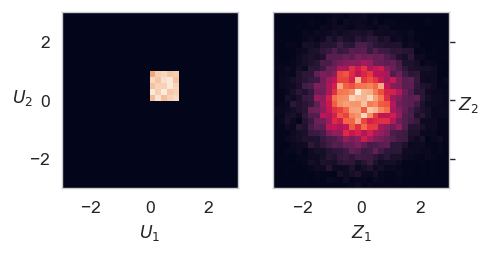

In [6]:
batch_size = 2**14
u = np.random.random(size=(batch_size, 2))
z = np.sqrt(-2*np.log(u[:,0]))[:,np.newaxis] * np.stack(
    (np.cos(2*np.pi*u[:,1]), np.sin(2*np.pi*u[:,1])), axis=-1)    # np stack >>>  (,-1) and (,-1) turns into (-1,2)

fig, ax = plt.subplots(1,2, dpi=125, figsize=(4,2))
for a in ax:
    a.set_xticks([-2, 0, 2])
    a.set_yticks([-2, 0, 2])
    a.set_aspect('equal')
ax[0].hist2d(u[:,0], u[:,1], bins=30, range=[[-3.0,3.0], [-3.0,3.0]])
ax[0].set_xlabel(r"$U_1$")
ax[0].set_ylabel(r"$U_2$", rotation=0, y=.46)
ax[1].hist2d(z[:,0], z[:,1], bins=30, range=[[-3.0,3.0], [-3.0,3.0]])
ax[1].set_yticklabels([])
ax[1].set_xlabel(r"$Z_1$")
ax[1].set_ylabel(r"$Z_2$", rotation=0, y=.53)
ax[1].yaxis.set_label_position("right")
ax[1].yaxis.tick_right()
plt.show()

In [7]:
class SimpleNormal:
    def __init__(self, loc, var):
        self.dist = torch.distributions.normal.Normal(
            torch.flatten(loc), torch.flatten(var))
        self.shape = loc.shape
    def log_prob(self, x):
        logp = self.dist.log_prob(x.reshape(x.shape[0], -1))
        return torch.sum(logp, dim=1)
    def sample_n(self, batch_size):
        x = self.dist.sample((batch_size,))
        return x.reshape(batch_size, *self.shape)

In [8]:
normal_prior = SimpleNormal(torch.zeros((3,4,5)), torch.ones((3,4,5)))     # This will be the piror distribution
z = normal_prior.sample_n(17)
print(f'z.shape = {z.shape}')
print(f'log r(z) = {grab(normal_prior.log_prob(z))}')      # Cell 4

z.shape = torch.Size([17, 3, 4, 5])
log r(z) = [-80.16518162 -81.84853599 -85.0454503  -94.82943828 -82.90930031
 -92.68043108 -88.841492   -83.47552737 -82.98802623 -83.78013452
 -77.55253322 -96.52565673 -81.63031584 -80.4797293  -90.58618466
 -87.17204082 -79.54701348]


In [9]:
class SimpleCouplingLayer(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.s = torch.nn.Sequential(
            torch.nn.Linear(1, 8),
            torch.nn.ReLU(),
            torch.nn.Linear(8, 8),
            torch.nn.ReLU(),
            torch.nn.Linear(8, 1),
            torch.nn.Tanh()
        )
    def forward(self, x):
        x1, x2 = x[:,0], x[:,1]
        s = self.s(x2.unsqueeze(-1)).squeeze(-1)
        fx1 = torch.exp(s) * x1
        fx2 = x2
        logJ = s
        return torch.stack((fx1, fx2), dim=-1), logJ
    def reverse(self, fx):
        fx1, fx2 = fx[:,0], fx[:,1]
        x2 = fx2
        s = self.s(x2.unsqueeze(-1)).squeeze(-1)
        logJ = -s
        x1 = torch.exp(-s) * fx1
        return torch.stack((x1, x2), dim=-1), logJ

coupling_layer = SimpleCouplingLayer()

# init weights in a way that gives interesting behavior without training
def set_weights(m):
    if hasattr(m, 'weight') and m.weight is not None:
        torch.nn.init.normal_(m.weight, mean=1, std=2)
    if hasattr(m, 'bias') and m.bias is not None:
        m.bias.data.fill_(-1)
torch.manual_seed(1234)
coupling_layer.s.apply(set_weights);

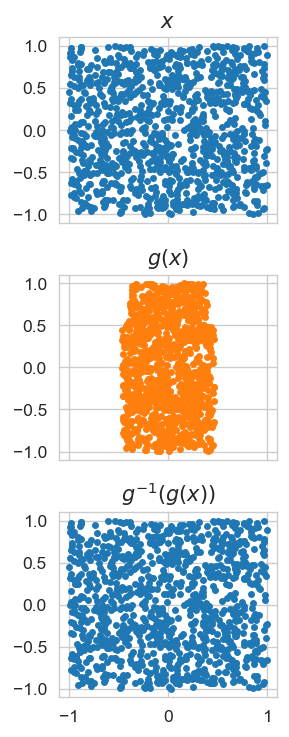

In [10]:
batch_size = 1024
np_x = (2*np.random.random(size=(batch_size, 2)) - 1).astype(float_dtype)
x = torch.from_numpy(np_x).to(torch_device)

gx, fwd_logJ = coupling_layer.forward(x)
xp, bwd_logJ = coupling_layer.reverse(gx)
        
fig, ax = plt.subplots(3,1, dpi=125, figsize=(2.3,6), sharex=True, sharey=True)
np_gx, np_xp = grab(gx), grab(xp)
for a in ax:
    a.set_xlim(-1.1,1.1)
    a.set_ylim(-1.1,1.1)
ax[0].scatter(np_x[:,0], np_x[:,1], marker='.')
ax[0].set_title(r'$x$')
ax[1].scatter(np_gx[:,0], np_gx[:,1], marker='.', color='tab:orange')
ax[1].set_title(r'$g(x)$')
ax[2].scatter(np_xp[:,0], np_xp[:,1], marker='.')
ax[2].set_title(r"$g^{-1}(g(x))$")
fig.set_tight_layout(True)
plt.show()

In [11]:
def apply_flow_to_prior(prior, coupling_layers, *, batch_size):
    x = prior.sample_n(batch_size)
    logq = prior.log_prob(x)
    for layer in coupling_layers:
        x, logJ = layer.forward(x)
        logq = logq - logJ
    return x, logq

In [12]:
L = 8
lattice_shape = (L,L)
phi_ex1 = np.random.normal(size=lattice_shape).astype(float_dtype)
phi_ex2 = np.random.normal(size=lattice_shape).astype(float_dtype)
cfgs = torch.from_numpy(np.stack((phi_ex1, phi_ex2), axis=0)).to(torch_device)
print(cfgs)
print(cfgs.shape)

tensor([[[ 0.1671, -0.0083, -0.8489,  0.7930, -0.0320,  2.2940,  1.0251,
          -0.1970],
         [ 0.7762, -0.7295, -0.8050, -0.5733,  0.4959,  0.3680, -1.2685,
           0.2473],
         [ 0.3291, -0.1072, -2.2123,  0.8418,  0.5510,  1.1561, -2.8211,
          -0.2563],
         [ 1.6412,  0.6402, -0.2930, -0.1171, -1.0095,  0.9593,  1.9213,
           0.1075],
         [-0.3722, -0.2652, -0.3306,  1.7571,  0.4242,  1.8025, -0.7086,
          -0.2218],
         [-0.0559, -0.6971, -0.8072,  0.8223,  1.3632,  0.4059,  0.8560,
          -0.3973],
         [ 0.4509,  0.9285,  0.0685, -0.1287, -0.3291,  0.2855, -0.7797,
           0.0136],
         [ 0.4331,  0.0558, -1.4950,  0.0443,  0.3219, -0.7133, -0.5107,
           1.0920]],

        [[ 0.6741, -0.4424, -0.1515,  0.6936,  0.3411,  0.7736,  0.8082,
          -0.1594],
         [ 1.6160,  0.2568, -0.0766,  1.5773, -0.8781,  0.8628,  0.3566,
           1.4968],
         [-0.6045,  1.9151, -0.2171,  0.2120,  0.1725, -1.0614,  0.5

In [13]:
class ScalarPhi4Action:
    def __init__(self, M2, lam):
        self.M2 = M2
        self.lam = lam
    def __call__(self, cfgs):
        # potential term
        action_density = self.M2*cfgs**2 + self.lam*cfgs**4
        # kinetic term (discrete Laplacian)
        Nd = len(cfgs.shape)-1
        dims = range(1,Nd+1)
        for mu in dims:
            action_density += 2*cfgs**2
            action_density -= cfgs*torch.roll(cfgs, -1, mu)
            action_density -= cfgs*torch.roll(cfgs, 1, mu)
        return torch.sum(action_density, dim=tuple(dims))

print("Actions for example configs:", ScalarPhi4Action(M2=1.0, lam=1.0)(cfgs))

Actions for example configs: tensor([446.7660, 508.1658])


In [14]:
M2 = -4.0
lam = 8.0
phi4_action = ScalarPhi4Action(M2=M2, lam=lam)

In [15]:
prior = SimpleNormal(torch.zeros(lattice_shape), torch.ones(lattice_shape))

z.shape = (1024, 8, 8)


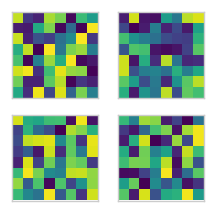

In [16]:
torch_z = prior.sample_n(1024)    
#Lattice_shape = (8,8) centered at zero with var equals to 0ne
z = grab(torch_z)
print(f'z.shape = {z.shape}')

fig, ax = plt.subplots(2,2, dpi=125, figsize=(2,2))
for i in range(2):
    for j in range(2):
        ind = i*2 + j
        ax[i,j].imshow(np.tanh(z[ind]), vmin=-1, vmax=1, cmap='viridis')
        ax[i,j].axes.xaxis.set_visible(False)
        ax[i,j].axes.yaxis.set_visible(False)
plt.show()

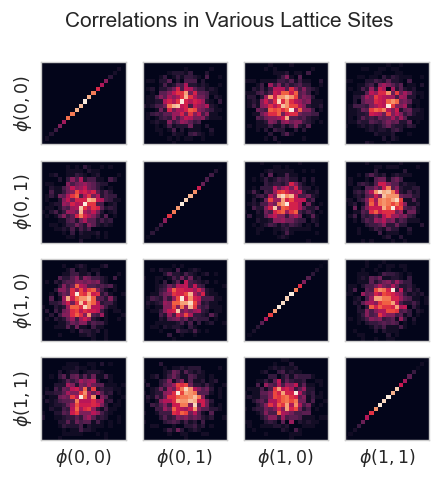

In [17]:
fig, ax = plt.subplots(4,4, dpi=125, figsize=(4,4))
for x1 in range(2):
    for y1 in range(2):
        i1 = x1*2 + y1
        for x2 in range(2):
            for y2 in range(2):
                i2 = x2*2 + y2
                ax[i1,i2].hist2d(z[:,x1,y1], z[:,x2,y2], range=[[-3,3],[-3,3]], bins=20)
                ax[i1,i2].set_xticks([])
                ax[i1,i2].set_yticks([])
                if i1 == 3:
                    ax[i1,i2].set_xlabel(rf'$\phi({x2},{y2})$')
                if i2 == 0:
                    ax[i1,i2].set_ylabel(rf'$\phi({x1},{y1})$')
fig.suptitle("Correlations in Various Lattice Sites")
plt.show()

slope 1 linear regression S = -logr + 1455.4647


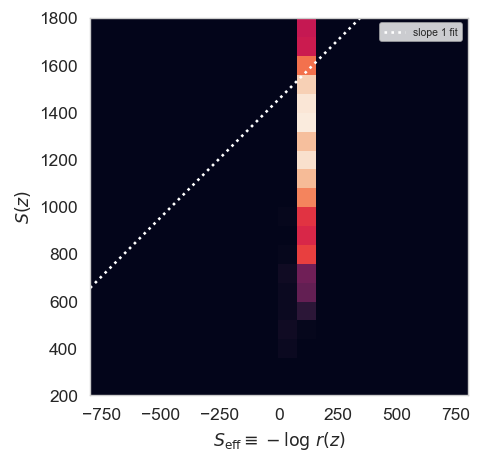

In [18]:
S_eff = -grab(prior.log_prob(torch_z))
S = grab(phi4_action(torch_z))
fit_b = np.mean(S) - np.mean(S_eff)
print(f'slope 1 linear regression S = -logr + {fit_b:.4f}')
fig, ax = plt.subplots(1,1, dpi=125, figsize=(4,4))
ax.hist2d(S_eff, S, bins=20, range=[[-800, 800], [200,1800]])
xs = np.linspace(-800, 800, num=4, endpoint=True)
ax.plot(xs, xs + fit_b, ':', color='w', label='slope 1 fit')
ax.set_xlabel(r'$S_{\mathrm{eff}} \equiv -\log~r(z)$')
ax.set_ylabel(r'$S(z)$')
ax.set_aspect('equal')
plt.legend(prop={'size': 6})
plt.show()

In [19]:
def make_checker_mask(shape, parity):
    checker = torch.ones(shape, dtype=torch.uint8) - parity
    checker[::2, ::2] = parity
    checker[1::2, 1::2] = parity
    return checker.to(torch_device)

print("For example this is the mask for an 8x8 configuration:\n",
    make_checker_mask(lattice_shape, 0))

For example this is the mask for an 8x8 configuration:
 tensor([[0, 1, 0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0, 1, 0]], dtype=torch.uint8)


In [20]:
class AffineCoupling(torch.nn.Module):
    def __init__(self, net, *, mask_shape, mask_parity):
        super().__init__()
        self.mask = make_checker_mask(mask_shape, mask_parity)
        self.net = net
    def forward(self, x):
        x_frozen = self.mask * x
        x_active = (1 - self.mask) * x
        net_out = self.net(x_frozen.unsqueeze(1))
        s, t = net_out[:,0], net_out[:,1]
        fx = (1 - self.mask) * t + x_active * torch.exp(s) + x_frozen
        axes = range(1,len(s.size()))
        logJ = torch.sum((1 - self.mask) * s, dim=tuple(axes))
        return fx, logJ
    
    def reverse(self, fx):
        fx_frozen = self.mask * fx
        fx_active = (1 - self.mask) * fx
        net_out = self.net(fx_frozen.unsqueeze(1))
        s, t = net_out[:,0], net_out[:,1]
        x = (fx_active - (1 - self.mask) * t) * torch.exp(-s) + fx_frozen
        axes = range(1,len(s.size()))
        logJ = torch.sum((1 - self.mask)*(-s), dim=tuple(axes))
        return x, logJ

In [21]:
def make_conv_net(*, hidden_sizes, kernel_size, in_channels, out_channels, use_final_tanh):
    sizes = [in_channels] + hidden_sizes + [out_channels]
    assert packaging.version.parse(torch.__version__) >= packaging.version.parse('1.5.0')
    assert kernel_size % 2 == 1, 'kernel size must be odd for PyTorch >= 1.5.0'
    padding_size = (kernel_size // 2)
    net = []
    for i in range(len(sizes) - 1):
        net.append(torch.nn.Conv2d(
            sizes[i], sizes[i+1], kernel_size, padding=padding_size,
            stride=1, padding_mode='circular'))
        if i != len(sizes) - 2:
            net.append(torch.nn.LeakyReLU())
        else:
            if use_final_tanh:
                net.append(torch.nn.Tanh())
    return torch.nn.Sequential(*net)

In [22]:
def make_phi4_affine_layers(*,n_layers, lattice_shape, hidden_sizes, kernel_size):
    layers = []
    for i in range(n_layers):
        parity = i % 2
        net = make_conv_net(
            in_channels=1, out_channels=2, hidden_sizes=hidden_sizes,
            kernel_size=kernel_size, use_final_tanh=True)
        coupling = AffineCoupling(net, mask_shape=lattice_shape, mask_parity=parity)
        layers.append(coupling)
    return torch.nn.ModuleList(layers)

In [23]:
n_layers = 16
hidden_sizes = [8,8]
kernel_size = 3
layers = make_phi4_affine_layers(
    lattice_shape=lattice_shape, n_layers=n_layers,
    hidden_sizes=hidden_sizes, kernel_size=kernel_size)
model = {'layers': layers, 'prior': prior}

In [24]:
def calc_dkl(logp, logq):
    return (logq - logp).mean() # reverse KL, assuming samples from q

In [25]:
def train_step(model, action, loss_fn, optimizer, metrics):
    layers, prior = model['layers'], model['prior']
    optimizer.zero_grad()
    
    x, logq = apply_flow_to_prior(prior, layers, batch_size=batch_size)
    logp = -action(x)
    loss = loss_fn(logp, logq)
    loss.backward()
    
    optimizer.step()
    
    metrics['loss'].append(grab(loss))
    metrics['logp'].append(grab(logp))
    metrics['logq'].append(grab(logq))
    metrics['ess'].append(grab( compute_ess(logp, logq) ))

In [26]:
def compute_ess(logp, logq):
    logw = logp - logq
    log_ess = 2*torch.logsumexp(logw, dim=0) - torch.logsumexp(2*logw, dim=0)
    ess_per_cfg = torch.exp(log_ess) / len(logw)
    return ess_per_cfg

In [27]:
def print_metrics(history, avg_last_N_epochs):
    print(f'== Era {era} | Epoch {epoch} metrics ==')
    for key, val in history.items():
        avgd = np.mean(val[-avg_last_N_epochs:])
        print(f'\t{key} {avgd:g}')

In [28]:
use_pretrained = False

In [29]:
# Lattice Theory
L = 8
lattice_shape = (L,L)
M2 = -4.0
lam = 8.0
phi4_action = ScalarPhi4Action(M2=M2, lam=lam)

# Model
prior = SimpleNormal(torch.zeros(lattice_shape), torch.ones(lattice_shape))

n_layers = 16
hidden_sizes = [8,8]
kernel_size = 3
layers = make_phi4_affine_layers(lattice_shape=lattice_shape, n_layers=n_layers,
    hidden_sizes=hidden_sizes, kernel_size=kernel_size)
model = {'layers': layers, 'prior': prior}

# Training
base_lr = .001
optimizer = torch.optim.Adam(model['layers'].parameters(), lr=base_lr)

In [30]:
if use_pretrained:
    print('Loading pre-trained model')
    phi4_trained_weights = torch.load(io.BytesIO(base64.b64decode(b"""
<snipped base64 blob>
    """.strip())), map_location=torch.device('cpu'))
    model['layers'].load_state_dict(phi4_trained_weights)
    if torch_device == 'cuda':
        model['layers'].cuda()
else:
    print('Skipping pre-trained model')

Skipping pre-trained model


In [31]:
N_era = 50
N_epoch = 100
batch_size = 64
print_freq = N_epoch
plot_freq = 500

history = {
    'loss' : [],
    'logp' : [],
    'logq' : [],
    'ess' : []
}

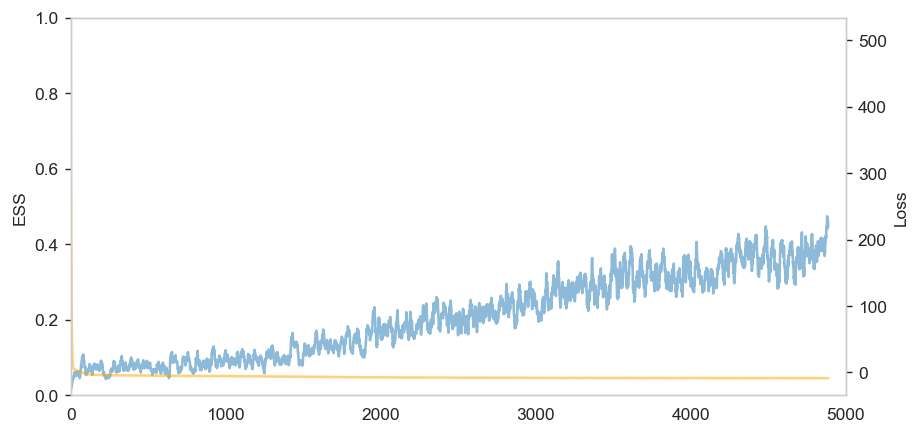

== Era 0 | Epoch 0 metrics ==
	loss 2239.26
	logp -2324.63
	logq -85.3729
	ess 0.015625
== Era 1 | Epoch 0 metrics ==
	loss 55.9363
	logp -66.4595
	logq -10.5233
	ess 0.0596619
== Era 2 | Epoch 0 metrics ==
	loss -3.25106
	logp -12.6339
	logq -15.885
	ess 0.0700543
== Era 3 | Epoch 0 metrics ==
	loss -4.13139
	logp -12.5976
	logq -16.729
	ess 0.0643392
== Era 4 | Epoch 0 metrics ==
	loss -4.45401
	logp -12.4943
	logq -16.9483
	ess 0.0773558
== Era 5 | Epoch 0 metrics ==
	loss -4.6879
	logp -12.5961
	logq -17.284
	ess 0.0804456
== Era 6 | Epoch 0 metrics ==
	loss -4.94291
	logp -12.5161
	logq -17.4591
	ess 0.0707823
== Era 7 | Epoch 0 metrics ==
	loss -5.03243
	logp -12.4835
	logq -17.5159
	ess 0.0810539
== Era 8 | Epoch 0 metrics ==
	loss -5.2261
	logp -12.4394
	logq -17.6655
	ess 0.0815118
== Era 9 | Epoch 0 metrics ==
	loss -5.37402
	logp -12.3307
	logq -17.7047
	ess 0.082268
== Era 10 | Epoch 0 metrics ==
	loss -5.52867
	logp -12.353
	logq -17.8817
	ess 0.0921436
== Era 11 | Epoch 0

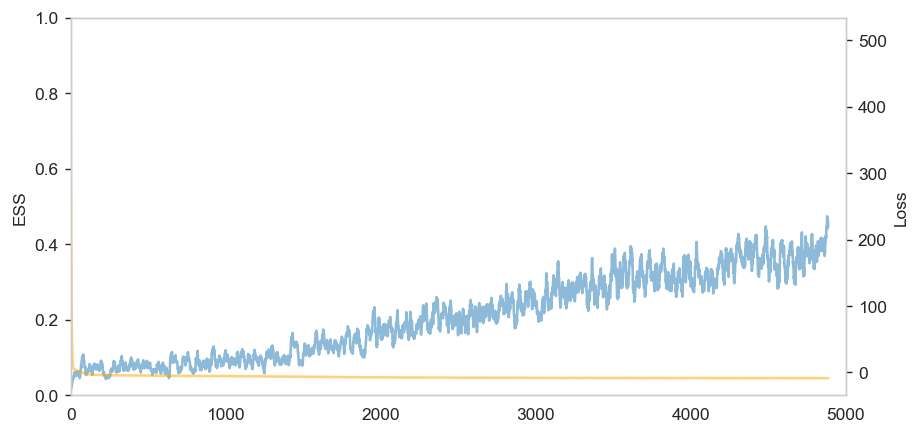

In [32]:
start_1 = time.time()
if not use_pretrained:
    [plt.close(plt.figure(fignum)) for fignum in plt.get_fignums()] # close all existing figures
    live_plot = init_live_plot()
    
    for era in range(N_era):
        for epoch in range(N_epoch):
            train_step(model, phi4_action, calc_dkl, optimizer, history)
        
            if epoch % print_freq == 0:
                print_metrics(history, avg_last_N_epochs=print_freq)
                
            if epoch % plot_freq == 0:
                update_plots(history, **live_plot)
                
else:
    print('Skipping training')

end_1 = time.time()
print(end_1-start_1)

In [33]:
print('Model weights blob:\n===')
serialized_model = io.BytesIO()
torch.save(model['layers'].state_dict(), serialized_model)
print(base64.b64encode(serialized_model.getbuffer()).decode('utf-8'))
print('===')

Model weights blob:
===
UEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAQABIAYXJjaGl2ZS9kYXRhLnBrbEZCDgBaWlpaWlpaWlpaWlpaWoACY2NvbGxlY3Rpb25zCk9yZGVyZWREaWN0CnEAKVJxAShYDgAAADAubmV0LjAud2VpZ2h0cQJjdG9yY2guX3V0aWxzCl9yZWJ1aWxkX3RlbnNvcl92MgpxAygoWAcAAABzdG9yYWdlcQRjdG9yY2gKRG91YmxlU3RvcmFnZQpxBVgNAAAAMTg5ODE0MTAwODExMnEGWAMAAABjcHVxB0tIdHEIUUsAKEsISwFLA0sDdHEJKEsJSwlLA0sBdHEKiWgAKVJxC3RxDFJxDVgMAAAAMC5uZXQuMC5iaWFzcQ5oAygoaARoBVgNAAAAMTg5ODE0MTAwODg4MHEPaAdLCHRxEFFLAEsIhXERSwGFcRKJaAApUnETdHEUUnEVWA4AAAAwLm5ldC4yLndlaWdodHEWaAMoKGgEaAVYDQAAADE4OTgxNDEwMDk0NTZxF2gHTUACdHEYUUsAKEsISwhLA0sDdHEZKEtISwlLA0sBdHEaiWgAKVJxG3RxHFJxHVgMAAAAMC5uZXQuMi5iaWFzcR5oAygoaARoBVgNAAAAMTg5ODE0MTAwOTU1MnEfaAdLCHRxIFFLAEsIhXEhSwGFcSKJaAApUnEjdHEkUnElWA4AAAAwLm5ldC40LndlaWdodHEmaAMoKGgEaAVYDQAAADE4OTgxNDEwMDk2NDhxJ2gHS5B0cShRSwAoSwJLCEsDSwN0cSkoS0hLCUsDSwF0cSqJaAApUnErdHEsUnEtWAwAAAAwLm5ldC40LmJpYXNxLmgDKChoBGgFWA0AAAAxODk4MTQxMDA5ODQwcS9oB0sCdHEwUUsASwKFcTFLAYVxMoloAClScTN0cTRScTVYDgAAADEubmV0LjAud2VpZ2h0cTZoAygoaARoBVgN

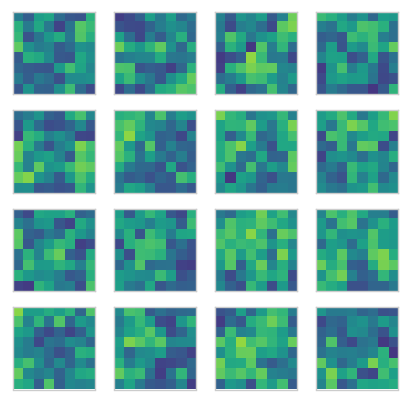

In [34]:
torch_x, torch_logq = apply_flow_to_prior(prior, layers, batch_size=1024)
x = grab(torch_x)

fig, ax = plt.subplots(4,4, dpi=125, figsize=(4,4))
for i in range(4):
    for j in range(4):
        ind = i*4 + j
        ax[i,j].imshow(np.tanh(x[ind]), vmin=-1, vmax=1, cmap='viridis')
        ax[i,j].axes.xaxis.set_visible(False)
        ax[i,j].axes.yaxis.set_visible(False)
plt.show()

slope 1 linear regression S = S_eff + -8.6243


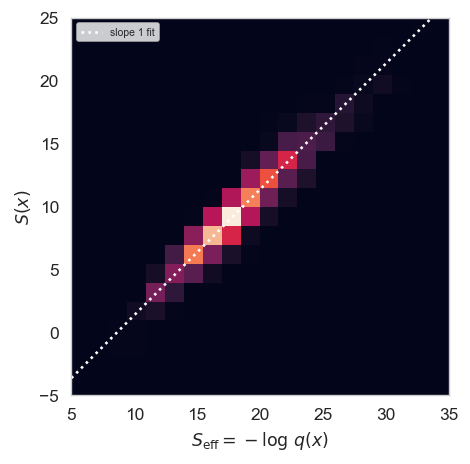

In [35]:
S_eff = -grab(torch_logq)
S = grab(phi4_action(torch_x))
fit_b = np.mean(S) - np.mean(S_eff)
print(f'slope 1 linear regression S = S_eff + {fit_b:.4f}')
fig, ax = plt.subplots(1,1, dpi=125, figsize=(4,4))
ax.hist2d(S_eff, S, bins=20, range=[[5, 35], [-5, 25]])
ax.set_xlabel(r'$S_{\mathrm{eff}} = -\log~q(x)$')
ax.set_ylabel(r'$S(x)$')
ax.set_aspect('equal')
xs = np.linspace(5, 35, num=4, endpoint=True)
ax.plot(xs, xs + fit_b, ':', color='w', label='slope 1 fit')
plt.legend(prop={'size': 6})
plt.show()

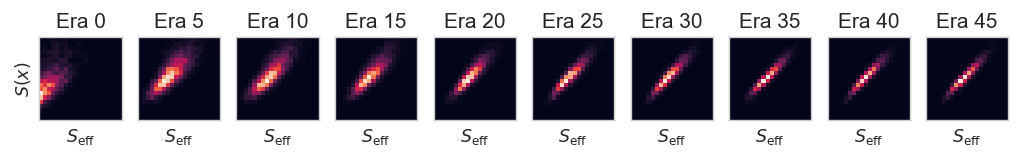

In [36]:
if not use_pretrained:
    fig, axes = plt.subplots(1, 10, dpi=125, sharey=True, figsize=(10, 1))
    logq_hist = np.array(history['logq']).reshape(N_era, -1)[::N_era//10]
    logp_hist = np.array(history['logp']).reshape(N_era, -1)[::N_era//10]
    for i, (ax, logq, logp) in enumerate(zip(axes, logq_hist, logp_hist)):
        
        ax.hist2d(-logq, -logp, bins=20, range=[[5, 35], [-5, 25]])
        
        if i == 0:
            ax.set_ylabel(r'$S(x)$')
        ax.set_xlabel(r'$S_{\mathrm{eff}}$')
        ax.set_title(f'Era {i * (N_era//10)}')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect('equal')
    plt.show()

In [37]:
print('You got two gold!')

You got two gold!


In [38]:
def serial_sample_generator(model, action, batch_size, N_samples):
    layers, prior = model['layers'], model['prior']
    layers.eval()
    x, logq, logp = None, None, None
    for i in range(N_samples):
        batch_i = i % batch_size
        if batch_i == 0:
            # we're out of samples to propose, generate a new batch
            x, logq = apply_flow_to_prior(prior, layers, batch_size=batch_size)
            logp = -action(x)
        yield x[batch_i], logq[batch_i], logp[batch_i]

In [39]:
def make_mcmc_ensemble(model, action, batch_size, N_samples):
    history = {
        'x' : [],
        'logq' : [],
        'logp' : [],
        'accepted' : []
    }
    
    # build Markov chain
    sample_gen = serial_sample_generator(model, action, batch_size, N_samples)
    for new_x, new_logq, new_logp in sample_gen:
        if len(history['logp']) == 0:
            # always accept first proposal, Markov chain must start somewhere
            accepted = True
        else:
                # Metropolis acceptance condition
                last_logp = history['logp'][-1]
                last_logq = history['logq'][-1]
                p_accept = torch.exp((new_logp - new_logq) - (last_logp - last_logq))
                p_accept = min(1, p_accept)
                draw = torch.rand(1) # ~ [0,1]
                if draw < p_accept:
                    accepted = True
                else:
                    accepted = False
                    new_x = history['x'][-1]
                    new_logp = last_logp
                    new_logq = last_logq
        # Update Markov chain
        history['logp'].append(new_logp)
        history['logq'].append(new_logq)
        history['x'].append(new_x)
        history['accepted'].append(accepted)
    return history

In [40]:
ensemble_size = 8192
phi4_ens = make_mcmc_ensemble(model, phi4_action, 64, ensemble_size)
print("Accept rate:", np.mean(phi4_ens['accepted']))

Accept rate: 0.4061279296875


In [41]:
n_therm = 512
cfgs = np.stack(list(map(grab, phi4_ens['x'])), axis=0)[n_therm:]
C = 0
for x in range(L):
    for y in range(L):
        C = C + cfgs*np.roll(cfgs, (-x, -y), axis=(1,2))
X = np.mean(C, axis=(1,2))

def bootstrap(x, *, Nboot, binsize):
    boots = []
    x = x.reshape(-1, binsize, *x.shape[1:])
    for i in range(Nboot):
        boots.append(np.mean(x[np.random.randint(len(x), size=len(x))], axis=(0,1)))
    return np.mean(boots), np.std(boots)
X_mean, X_err = bootstrap(X, Nboot=100, binsize=4)
print(f'Two-point susceptibility = {X_mean:.2f} +/- {X_err:.2f}')
print(f'... vs HMC estimate = 0.75 +/- 0.01')

Two-point susceptibility = 0.72 +/- 0.02
... vs HMC estimate = 0.75 +/- 0.01
